In [1]:
from astropy.io import fits
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import resample

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

%matplotlib inline

/Users/marcolam/git/rascal/rascal/calibrator.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data = fits.open('data_wht_isis/r2701004_red_arc.fit')[1]

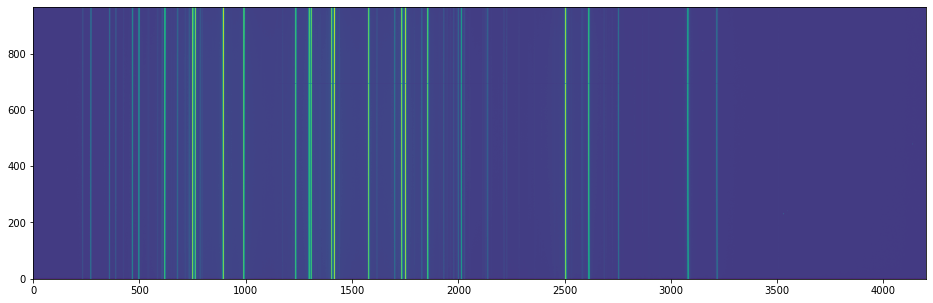

In [3]:
plt.figure(1, figsize=(16,5))
plt.imshow(np.log(data.data.T), aspect='auto', origin='lower')

In [4]:
spectrum = np.median(data.data.T, axis=0)

peaks, _ = find_peaks(spectrum, prominence=80, distance=20, threshold=None)

peaks_refined = refine_peaks(spectrum, peaks, window_width=3)

INFO:rascal.calibrator:num_pix is set to None.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.
INFO:rascal.calibrator:num_pix is set to 4200.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.


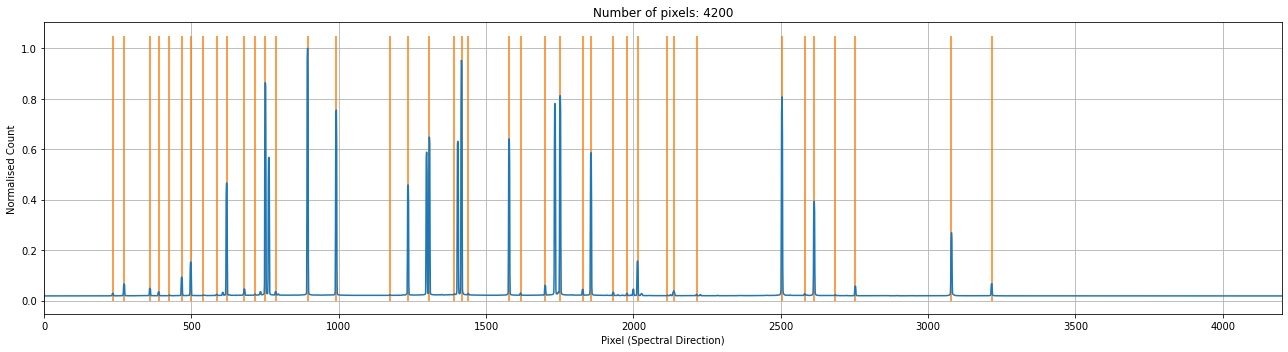

In [5]:
c = Calibrator(peaks_refined, spectrum)

c.set_calibrator_properties(num_pix=len(spectrum),
                            plotting_library='matplotlib',
                            log_level='info') 

c.plot_arc()

In [6]:
c.set_hough_properties(num_slopes=10000,
                       xbins=500,
                       ybins=500,
                       min_wavelength=7000.,
                       max_wavelength=10500.,
                       range_tolerance=500.,
                       linearity_tolerance=50)
c.add_atlas(["Ne", "Ar", "Cu"],
            min_atlas_wavelength=6000,
            max_atlas_wavelength=11000,
            min_intensity=10,
            min_distance=10,
            candidate_tolerance=10,
            constrain_poly=False,
            vacuum=False,
            pressure=101325.,
            temperature=273.15,
            relative_humidity=0.)
c.set_ransac_properties(sample_size=5,
                        top_n_candidate=5,
                        linear=True,
                        filter_close=True,
                        ransac_tolerance=5,
                        candidate_weighted=True,
                        hough_weight=1.0)
c.do_hough_transform()

INFO:rascal.calibrator:Peak at: 7032.306220869941 A
INFO:rascal.calibrator:- matched to 7030.16748046875 A
INFO:rascal.calibrator:Peak at: 7067.085032456408 A
INFO:rascal.calibrator:Peak at: 7146.814043832636 A
INFO:rascal.calibrator:- matched to 7146.95654296875 A
INFO:rascal.calibrator:Peak at: 7173.753783228431 A
INFO:rascal.calibrator:- matched to 7173.85205078125 A
INFO:rascal.calibrator:Peak at: 7206.775792766092 A
INFO:rascal.calibrator:- matched to 7206.892578125 A
INFO:rascal.calibrator:Peak at: 7245.085222225744 A
INFO:rascal.calibrator:- matched to 7245.0791015625 A
INFO:rascal.calibrator:Peak at: 7272.757999622807 A
INFO:rascal.calibrator:Peak at: 7311.784727303266 A
INFO:rascal.calibrator:Peak at: 7353.576397168573 A
INFO:rascal.calibrator:- matched to 7353.20361328125 A
INFO:rascal.calibrator:Peak at: 7383.855473178811 A
INFO:rascal.calibrator:Peak at: 7438.931116149874 A
INFO:rascal.calibrator:- matched to 7438.80712890625 A
INFO:rascal.calibrator:Peak at: 7471.616623762

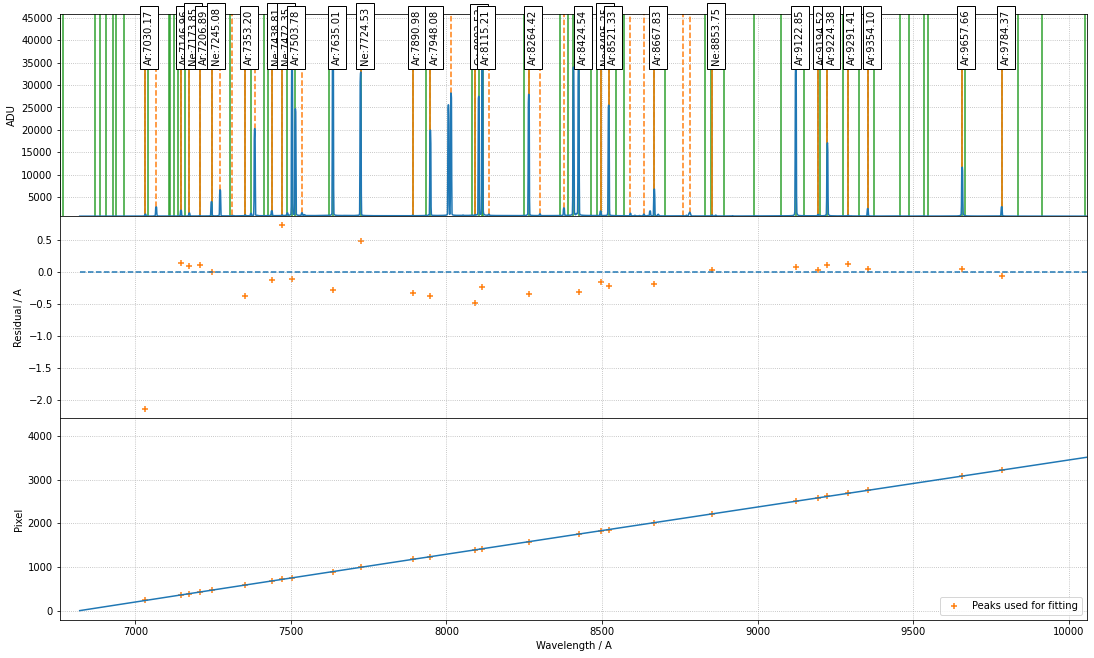

Stdev error: 0.494672480445691 A
Peaks utilisation rate: 165.85365853658536%


In [7]:
best_p, rms, residual, peak_utilisation = c.fit(max_tries=1000)

c.plot_fit(best_p, plot_atlas=True, log_spectrum=False, tolerance=5.0, renderer='notebook')


rms = np.sqrt(np.sum(residual**2 / len(residual)))

print("Stdev error: {} A".format(np.abs(residual).std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

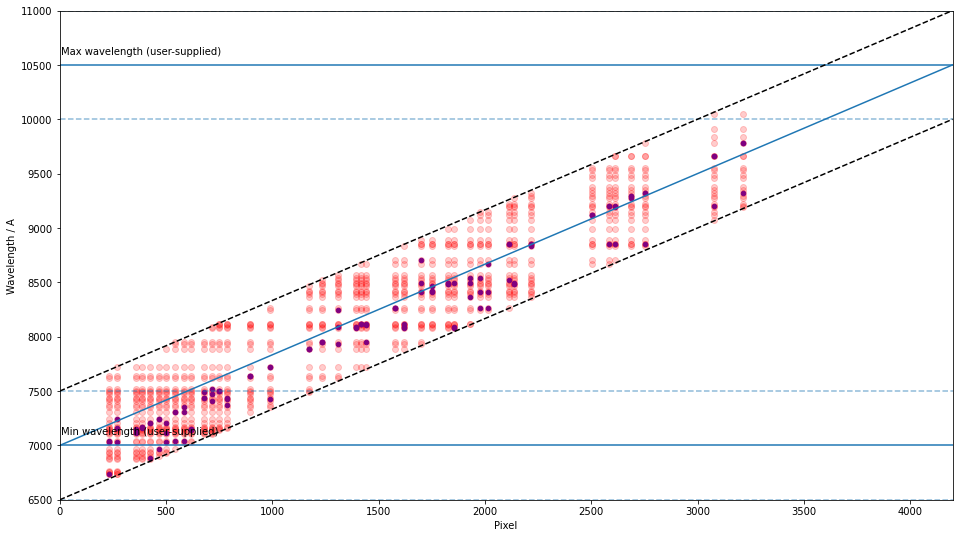

In [8]:
c.plot_search_space()